In [95]:
%load_ext autoreload
%autoreload 2
%autosave 60

from petmarrna.libs import *
%run -i common.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 60 seconds


** Using data resources found in resources.json
** Using config found in config.json


In [96]:
%pylab inline
import seaborn as sns
sns.set_style('ticks')
sns.set_palette('hls')
figsize(12,8)

Populating the interactive namespace from numpy and matplotlib


In [97]:
from IPython.display import Latex, HTML, Image

In [98]:
# Slideshow configuration

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'serif',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
})

{u'start_slideshow_at': 'selected', u'theme': 'serif', u'transition': 'zoom'}

In [99]:
HTML('''<style>
        .right_aligned_df td { text-align: right; }
        .left_aligned_df td { text-align: right; }
        .no_border_df table {border: none;}
        </style>''')

### Many-Sample *de novo* Transcriptome Analysis of the cyclostome *P. marinus*

#### or, how I learned to stop worrying and love the lamprey

-----

![lamprey](http://upload.wikimedia.org/wikipedia/commons/2/28/Petromyzon_marinus.jpg)

-----

##### Camille Scott 2015-09-23
##### DIB Lab Meeting
##### University of California, Davis

-----
### Overview

1. Concerning Lampreys *("this is dumb, why do I care?")* 
2. Project Goals
2. Challenges           *("transcriptomes are dumb, why do I care?")*
3. Results *("can de novo assembly actually *do* anything?)*
  
4. Related Projects *("why haven't you published this yet?")*
5. Endmatter *("just let me leave")*
-----

#### Meta

I'd prefer to answer questions at the end, so I request we keep interruptions at a minimum :)

-----
### Concerning Lampreys

* *P. marinus*, common name Sea lamprey, is a species of parasitic lamprey
    - There are 38 lamprey species, 17 of which are parasitic (Hardisty 2006)
* Lampreys are *jawless* vertebrates, or *agnathans*
    - Along with hagfish, they compose the *cyclostomes*
    - They are the closest extent relative of the ancestor to jawed vertebrates, the *gnathostomes*
    - As such, they're an important species for understanding vertebrate evolution (Smith 2013)
-----    

-----
![Abridged vertebrate phylogeny](figures/ng.2568-F1.jpg)

<center>*An abridged vertbrate phylogeny (Smith 2013)*</center>

-----

-----
### About the Project

<br>
<center> "What can we do with 84 RNA-seq samples of varying quality?" </center>

-----

In [100]:
def get_table(df, columns):
    formatters={'paired': lambda x: 'paired' if x else 'single',
                'label': lambda x: ' '.join(x.split('_'))}
    return HTML(df.to_html(index=False, columns=columns, header=False, 
                           classes='no_border_df', formatters=formatters).replace('border="1"','border="0"'))

In [101]:
sub = get_table(sample_df.ix[:10], ['label', 'tissue', 'paired'])

-----

{{sub}}

-----

-----

#### As it turns out, a lot!

* Transcriptome assembly, which leads to...
    - Gene-content assessment
    - Genome cross-validation
    - Isoform characterization
    - Differential expression
    
-----

-----

### Goal

* So, our goal is to produce a high-quality set of reference transcripts for the sea lamprey community
* We chose de novo assembly due to an incomplete reference genome
* This wealth of new data should allow us to address some fundamental questions about vertebrate evolution

-----

-----

### Challenges

* A lot of our data is old -- 36bp Solexa reads.
* Our data was generated by many different people in multiple labs and sequencing centers.
* There is a *lot* of it -- 3-5 billion reads, depending on what we include.
* Error starts to become unmanageable with increasing coverage

-----

-----
* Programmed Genome Rearrangement
    - Sea lampreys undergo a programmed genome rearrangement during embryonic development

    <br>
    <center>![PGR](http://www.pnas.org/content/106/27/11212/F1.medium.gif)</center>
    <center>*DNA weight in soma and germline (Smith 2009)*</center>

    - So not only will our different tissues produce different transcripts due to alternative splicing, but because they originate from different genomes!
-----

-----

* High GC Content
    - 46% for the whole genome
    - 67% for the coding regions (Smith 2013)
-----

-----

#### Methods
##### How are we confronting those challenges?

1. Pooled de novo assembly
    - Maximizes sensitivity at the cost of specificity
    - Confronts the issue of some of our samples being old and low-coverage
    - Confronts the reference genome issue
2. Extreme Preprocessing
    - Digital normalization to remove redundant reads and shift coverage profile
    - Abundance filtering to remove redundant and error-prone reads
3. Cross-validation
    - Germline DNA to cross-validate transcripts

-----

In [102]:
trim_cfg = config['pipeline']['trimmomatic']['params']
dg_cfg = '-C {coverage} -k {ksize}'.format(**config['pipeline']['khmer']['normalize']['single'])
abund_cfg = '-V -Z {coverage} -C {min_abund}'.format(**config['pipeline']['khmer']['filter-abund'])

-----

#### Pipeline Sketch

##### Preprocessing
1. Trimmomatic
   - `{{trim_cfg}}`
2. Digital normalization.
   - Two passes: first, each sample individually; then, a run through all samples.
   - `{{dg_cfg}}`
3. Abundance filtering
   - Variable coverage flag, using the k-mer catalogue from the pooled digital normalization
   - `{{abund_cfg}}`

-----

-----

##### Assembly and Beyond
4. Trinity (Grabherr 2011)
   - This is run with a variety of settings
   - Usually with `--jaccard_clip` and one of `--PasaFly` or `--CuffFly`, to reduce erroneous transcripts
5. Post-processing analysis
   - Homology and orthology search
   - Genome cross-validation
   - Coding region prediction
   - Annotation
  
-----

-----

### Assembly Results

* Our assembly is codenamed `lamp10`, which is quite creative. 
    - It's the tenth iteration of the main line of assemblies (not counting subsets, test runs, and so forth).
* `petMar2.cdna` or `lamp00` refer to the existing set of ab initio reference transcripts.

In [103]:
stats = {
    "med": 349.0,
    "N50len": 670,
    "max": 13664,
    "25_mers": 363607535,
    "N": 715345,
    "25_mers_unique": 240174557,
    "redundancy": 0.34,
    "GCperc": 0.49,
    "min": 201,
    "sum": 382206505,
    "N50pos": 565212,
    "mean": 534.29674492727281
}

N = stats['N']
N50 = stats['N50len']
kmer_redundancy = stats['redundancy']
GC = stats['GCperc']

#### Basic Properties



 Stat     |   Result    
----------|-------------
 N        |     {{N}}   
 N50      |     {{N50}} 
 GC       |     {{GC}}  
 Redundancy  |     {{kmer_redundancy}}


<center><small> redundancy is measured $1.0 - \frac{kmers_{unique}}{kmers_{total}}$ </small></center>



These simple stats actually tell us a lot. Firstly, our transcriptome is BIG. That's a lot transcripts. Secondly, it has a lot of redundancy -- 34% of all k-mers are non-unique. This is not entirely surprising with our pooled approach, but it's important to know.

-----

-----

#### Completeness

We can assess completeness in terms of gene recall using BUSCO, a program similar to cegma, which searches a database for a curated group of core genes (Zdobnov 2015).

In [19]:
from petmarrna import buscotools as bt
with open('results/busco.results.json') as fp:
    busco_data = json.load(fp)
    busco_data = bt.formatted(pd.DataFrame(busco_data))

An aside: major kudos to the cegma authors for directing users to BUSCO on their site.

-----

In [21]:
busco_data

metazoa                     vertebrata                     
                   C(%) D(%) F(%) M(%)    n       C(%) D(%) F(%) M(%)     n
fn                                                                         
lamp10.fasta         66   43   27  5.9  843         38   23   10   50  3023
petMar2.cdna.fa      48  6.4   15   36  843         28  2.0  5.1   66  3023

<center><small> *C=Complete Gene, D=Duplicate Gene, F=Fragmented, M=Missing, n=BUSCO group size* </small></center>

Two things stand out here:

   1. Our assembly has much better recall than lamp00 in both databases
   2. Both lamprey transcriptomes perform much better on the metazoan database than the vertebrata. 
       - This is likely due to the vertebrate database being biased for genes lost in lamprey
       - An evaluation of *Branchiostoma floridae* (the model cephalochordate) will be added for a control

-----

-----

#### Cross-validation

* Genome homologies and annotation overlap
* Homologies and orthologies to external databases

In [22]:
store = pd.HDFStore('_work/petMarSB.store.h5', complib='zlib', complevel=5)
blast_df = store['lamp10_blast_filter_df']

In [37]:
n_genome_hits = blast_df['lamp10.fasta.x.petMar2.fa.db.tsv'].sum()
p_genome_hits = '{:.1f}'.format(float(n_genome_hits) / len(blast_df) * 100)

##### Genome

{{p_genome_hits}}% of transcripts align to the genome with high confidence ({{n_genome_hits}} total).

That's a lot of genome hits, coming from a huge transcriptome sequence with lots of redundancy.

Perhaps there's something happening here.

-----

In [42]:
genome_df = store['lamp10.fasta.x.petMar2.fa.db.tsv']

In [48]:
genome_df_counted = genome_df.reset_index().groupby('qseqid').count()

In [66]:
n_multi_hits = len(genome_df_counted.query('sseqid > 2'))

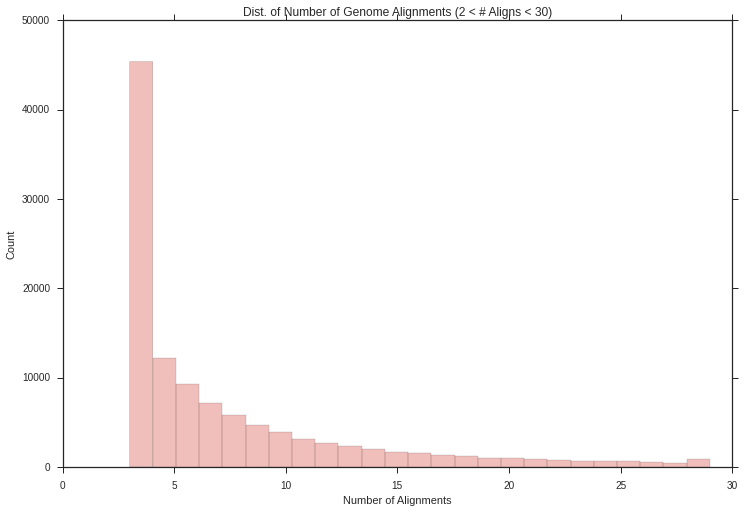

In [62]:
sns.distplot(genome_df_counted.query('2 < sseqid < 30').sseqid, kde=False, bins=25)
title('Dist. of Number of Genome Alignments (2 < # Aligns < 30)')
xlabel('Number of Alignments')
ylabel('Count')

A large number of transcripts have multiple alignments. {{n_multi_hits}} have 3 or more, with some having up to thousands of hits. This suggests repetitive sequence.

![lowcomp](figures/aln_lgth_vs_low_comp.png)

Indeed, many of the transcripts intersect with repetitive regions of the genome.

-----

We hypothesize a few possible reasons for this:

1. There's a lot of garbarge in the transcriptome. This is the default answer, but is boring and lazy.
2. There's contamination. We go through a lot of prefiltering, but still possible.
3. Piles and piles of retrotransposons.
    - The lamprey genome has tons of transposons -- they compose over 30% of it.
    - A search agains Rfam is currently running.
4. I'm open to more theories...

-----

#### Genome Annotations

Overlap with genome annotations further supports the validity of our transcripts. Lack of concordance here does not suggest an invalid transcript, however -- the gene models were generated ab initio with only some RNA-seq data.

In [71]:
with open('results/petmar-cross-validate.results.json') as fp:
    crossval_data = json.load(fp)

![Prop annot covered per cutoff](figures/prop_annot_per_cutoff.png)

-----

#### Other Species

We currently use a collection of databases from well-annotated species at convenient locations in the evolutionary tree.

* All Myxinidae (hagfish)
* *B. floridae* (amphioxus, a model cephalochordate)
* *D. rero* (zebrafish, a model teleoist fish)
* *M. musculus* (mouse)
* *H. sapiens* (mostly harmless)
* *P. marinus* proteins, cdna, ncRNA, and DNA

We are also incorporating Pfam-A, Rfam, OrthoDB, and uniref90 for annotation purposes, though results are not available yet.

-----

In [82]:
with open('results/petmar-genome-comp.results.json') as fp:
    comp_data = json.load(fp)

In [83]:
n_genome_supported = comp_data['n_genome_supported']
n_novel_ortho = comp_data['n_novel_ortho']
n_supported_ortho = comp_data['n_supported_ortho']

In [84]:
ortho_df = store['lamp10_ortho_filter_df']

In [89]:
# Transcripts with recipricol best thits to our main databases
has_ortho = ((ortho_df['lamp10.fasta.x.braFlo.pep.all.fa.db.tsv'] == True) | 
             (ortho_df['lamp10.fasta.x.danRer.pep.fa.db.tsv'] == True) |
             (ortho_df['lamp10.fasta.x.homSap.pep.fa.db.tsv'] == True) |
             (ortho_df['lamp10.fasta.x.musMus.pep.fa.db.tsv'] == True) |
             (ortho_df['lamp10.fasta.x.Myx.pep.all.fa.db.tsv'] == True))

In [93]:
n_orthos = has_ortho.sum()

-----

##### Summary

We use Reciprocal Best Hits (RBH) BLAST to establish high-confidence orthologies.

* {{n_orthos}} transcripts have strong orthologies
* {{n_supported_ortho}} transcripts have strong orthologies with lamprey support
* {{n_novel_ortho}} have orthologies and *no* lamprey support

The first number is low because using only these databases gives an incomplete picture; further, we need more sensitivty, ie. `hmmer` and Pfam-A. My preliminary results put the total number of transcripts with any good orthology or protein annotation at ~100,000, but I am not including those results until I have a good reproducible way to generate them.

-----

-----

We're particularly interested in those 1786 transcripts with no lamprey support; a more detailed analysis is in the lamprey repository: https://github.com/dib-lab/2015-petMarSB/blob/master/petmar-genome-completeness.ipynb

* In gnathostomata or cyclostomata, not cephalochordata: 796
* In gnathostomata and cyclostomata, not cephalochordata: 60
* In gnathostomata, not cyclostomata or cephalochordata: 736

That last number is great -- 736 genes which are **not** in the any current cyclostome or cephalochordate databases, but are in gnathostomes. Which is to say, these genes which previously only had evidence of existing in jawed vertebrates now have evidence of existing in jawless vertebrates as well, which implies they may have existed in the vertebrate ancestor.

-----

-----

### Related Projects

This project has generated several other projects and software along the way!

-----

-----

#### Eel Pond

* https://khmer-protocols.readthedocs.org/en/latest/mrnaseq/
* Not directly a product of lamprey, but its methods were heavily driven by the lamprey project.
* The lamprey pipeline encodes a version of the protocols using pydoit
    - https://github.com/dib-lab/2015-petMarSB/blob/master/pipeline

-----

-----

#### Joshua

The annotation overlap results rely on a fast Interval Tree implementation. An existing version is in bx-python, but it's hard to use, not well packaged, and lacking some core features. I repackaged and extended it, and it can be found here: https://github.com/camillescott/joshua

It's super fast! A couple orders of magnitude faster than the pure python version.

-----

-----

#### dammit!

A big part of this project is annotation, which is really frustrating. So, I finally broke down and wrote a transcriptome annotater. It is nearly complete, and lives here: https://github.com/camillescott/dammit

Some key features:

* Automates database and dependency download.
* Annotates using hmmer and Pfam-A, infernal and Rfam, LAST against OrthoDB and Uniref, and any user supplied protein databases.
* Runs assembly statistics (the ones earlier in the presentation were generated by it) and BUSCO.
* Is easy to use: `dammit annotate <transcriptome.fasta>`

I will keep the lab informed as to when it's ready for wider use, which will be quite soon -- I've poured a lot of time into this recently.

In the future, once the annotation functionality is solid, I will likely allow users to incorporate GFF models as well.

-----

-----

#### Peasoup

Peasoup is deprecated and ugly and you should not use it. The useful parts are being cannibalized and slowly moved to other repositories. However, I'd be remiss not to mention it, as a lot of my code lived there at one point.

-----

-----

### Endmatter

Many thanks and kudos to Titus and Weiming Li for their guidance; Eli and Likit for their help and discussions; the rest of their lab for many meetings and conversations; Erich Schwarz for giving me diabolical ideas; NIFA for funding me for a couple years; and all the other customary thanks that I'm forgetting.

-----

### Bibliography

    Grabherr, Manfred G, Brian J Haas, Moran Yassour, Joshua Z Levin, Dawn A Thompson, Ido Amit, Xian Adiconis, et al. 2011. “Full-Length Transcriptome Assembly from RNA-Seq Data without a Reference Genome.” Nature Biotechnology 29 (7): 644–52. doi:10.1038/nbt.1883.

    Hardisty, M.W. 2006. Lampreys: Life Without Jaws. Forrest. https://books.google.com/books?id=HoMWAQAAIAAJ.
    
    Simao, F. A., R. M. Waterhouse, P. Ioannidis, E. V. Kriventseva, and E. M. Zdobnov. 2015. “BUSCO: Assessing Genome Assembly and Annotation Completeness with Single-Copy Orthologs.” Bioinformatics, June. doi:10.1093/bioinformatics/btv351.
    
    Smith, J. J., F. Antonacci, E. E. Eichler, and C. T. Amemiya. 2009. “Programmed Loss of Millions of Base Pairs from a Vertebrate Genome.” Proceedings of the National Academy of Sciences 106 (27): 11212–17. doi:10.1073/pnas.0902358106.
    
    Smith, Jeramiah J, Shigehiro Kuraku, Carson Holt, Tatjana Sauka-Spengler, Ning Jiang, Michael S Campbell, Mark D Yandell, et al. 2013. “Sequencing of the Sea Lamprey (Petromyzon Marinus) Genome Provides Insights into Vertebrate Evolution.” Nature Genetics 45 (4): 415–21. doi:10.1038/ng.2568.